# **Generative Adversarial Networks (GANs)**

In this notebook, I will build a **Generative Adversarial Network (GAN)** and train it on images of Monet paintings and photos of various subjects. The goal is for the trained model to be able to transform photos into images that looke like Monet paintings.

A GAN consists of two kinds of neural networks that are trained in competition with each other: **generators** and **discriminators**. 

A **generator** tries to transform the images in the source set (in our case the photos) into images that look like they belong to the goal set (the Monet paintings). A **discriminator** tries to determine if an image really is of a Monet painting, or if it's a fake, i.e. a photograph transformed to look like a Monet. By competing against each other over a number of epochs, the generator and discriminator will both get better at their respective tasks.

In the setup in this notebook, there will also be a generator transforming images in the other direction: from Monet paintings to photos, and a discriminator that tries to determine if an image is a real or a fake photo.

The project is based on the Kaggle getting-started competition [I'm Something of a Painter Myself[(https://www.kaggle.com/competitions/gan-getting-started/overview).

The code in this notebook can be accessed in my GitHub repository [DTSA-5511-M5-Kaggle-GAN-Monet-Faker](https://github.com/OlaKlingberg/DTSA-5511-M5-Kaggle-GAN-Monet-Faker).

# **Data**

The data used in this notebook is in TFRecords format and consists of:
* 300 Monet images of Monet paintings.
* 7,038 photos (though the competition page on Kaggle says that there are just 7,028).

All images are RGB (i.e. color) images of size 256 x 256 pixels.



# **Plan**

## Exploratory Data Analysis 
After loading the data, I will output a few images of Monet paintings and a few photos. I will check the number of images, and confirm that they all have the correct size.

## Data cleaning
Assuming that the photos look like photos, the Monets look like Monets, and that all images have the correct size, there is no data cleaning to do.

## Model building
I will built the generators and discriminators and output graphs showing their architecture. I will put the generators and discriminators into a custom class that will be used for the training.

## Training and testing the model
After training the model on the entire sets of images, I will use the trained model to generate and output a few Monet-style images based on photos.

## Evaluating the model
The trainig of the model will generate four different loss values: the Monet generator loss, the Monet discriminator loss, the Photo generator loss, and the Photo discriminator loss. But the Kaggle competition is evaluated using MiFID (Memorization-Informed Fréchet Inception Distance), which is not computable based on these loss values. To find the MiFID score, I will make a submission to the Kaggle competition. The submission will consist of the entire set of photos, transformed by the trained model into Monet-style images.

## Hyper-parameter tuning
I will tune three hyper-parameters:
* Learning rare: 0.0001, 0.0002, 0.0004
* Batch size: 1, 2, 4
* Number of epochs: 15, 25, 40

Since the training of the model is time consuming, I don't aim at exploring all the 27 combinations of the values above.





# **Imports**

In [1]:
!pip install pydot # Needed for printing the model architectures

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets

from IPython.display import FileLink

import PIL

import shutil

2024-10-31 12:50:40.528438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 12:50:40.528542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 12:50:40.642178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Configure processor use**


In [3]:
# This code let's us use TPU, GPU, or CPU, in that order, based on availability.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on GPU.
Number of replicas: 1
2.15.0


# **Configurations to explore**

In [4]:
LEARNING_RATE = 0.00005 # Start with 0.0002, then 0.0001
BATCH_SIZE = 2 # Start with 1, then 2. If improvement, try 4.
EPOCHS = 25 # Start with 15. Increase if losses don't plateau.

# **Load the data**

In [5]:
# Get the Kaggle path to the data
GCS_PATH = KaggleDatasets().get_gcs_path()

In [6]:
# Get the names of the TFRecords file and output their number
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
IMAGE_SIZE = [256, 256] # Size according to info on the competition page

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # Normalize to [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [8]:
# # Function to extract the images
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [9]:
# Load the data sets
monet_ds = load_dataset(MONET_FILENAMES) 
photo_ds = load_dataset(PHOTO_FILENAMES) 

# **Exploratory Data Analysis**

In [10]:
# Check the number of images in each data set
monet_count = 0
for _ in monet_ds:
    monet_count += 1

print(f"Number of images in monet_ds: {monet_count}")

photo_count = 0
for _ in photo_ds:
    photo_count += 1

print(f"Number of images in photo_ds: {photo_count}\n")

Number of images in monet_ds: 300
Number of images in photo_ds: 7038



In [11]:
# Check image dimensions and channels
def check_image_shapes(dataset, dataset_name):
    for i, image in enumerate(dataset):
        # Get the shape of the image
        shape = image.shape
        if shape != (256, 256, 3):
            print(f"Mismatch in {dataset_name}: Image {i} has shape {shape}")
            return  # Stop if there's an issue
    print(f"All images in {dataset_name} are of shape (256, 256, 3)")

# Check both datasets
check_image_shapes(monet_ds, "Monet Dataset")
check_image_shapes(photo_ds, "Photo Dataset")

All images in Monet Dataset are of shape (256, 256, 3)
All images in Photo Dataset are of shape (256, 256, 3)


## Batch the images

In [12]:
# Batch the images
monet_ds = monet_ds.batch(BATCH_SIZE)
photo_ds = photo_ds.batch(BATCH_SIZE) 

## Show 4 photos and 4 Monets

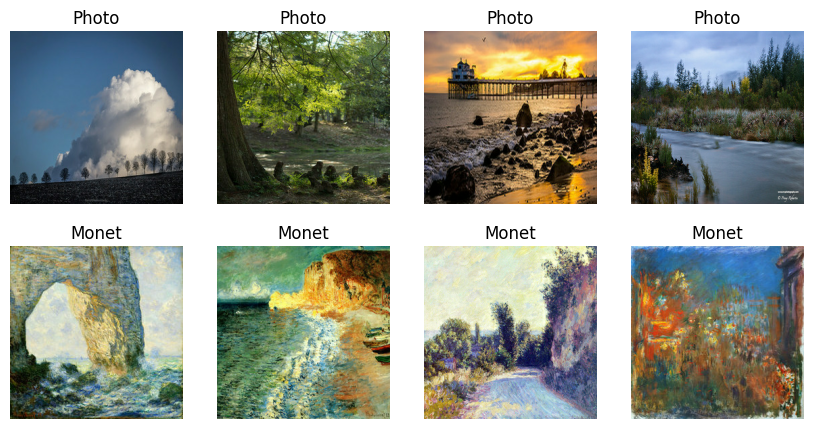

In [13]:
# Create iterables from the datasets
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

# Calculate figsize to display images at true size
figsize = (256 * 4 / 100, 256 * 2 / 100)  # 4 columns by 2 rows, at 256x256 pixels per image

fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=100)  # Set dpi to 100 to match pixel size

# Display 4 pairs of images
for i in range(4):
    # First row for Photos
    photo = next(photo_iter)
    ax[0, i].imshow(photo[0] * 0.5 + 0.5)
    ax[0, i].set_title("Photo")
    ax[0, i].axis('off')

    # Second row for Monet
    monet = next(monet_iter)
    ax[1, i].imshow(monet[0] * 0.5 + 0.5)
    ax[1, i].set_title("Monet")
    ax[1, i].axis('off')

plt.show()

# **Build the CycleGAN model**

Our model will have two generators and two discriminators.

The two generators will have identical architecture, as will the two discriminators. 

## Generators

The task of the Monet Generator is to generate fake Monet paintings based on photos, while the Photo Generator should generate fake photos based on Monet paintings.

### Encoder and decoder
Each generator consists of an **encoder** and a **decodeer**. The encoder is a stack of functions that downsample the image, i.e. reduces its spatial dimensions, step by step, from the original 256 x 256 pixel image all the way down to 1 x 1. At the same time, it generates an increasing number of feature maps, which represent different aspects of the image.

The decoder reverses the process. It's a stack of functions that upsamples the image, i.e. increases its spatial dimensions, step by step, till we have reached the original dimension, while decresing the number of feature maps.

We'll start by creating the downsampling and upsampling functions.



In [14]:
OUTPUT_CHANNELS = 3

# Downsampling function for the encoder
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides = 2, padding = 'same',
                             kernel_initializer = initializer, use_bias = False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1))

    result.add(layers.LeakyReLU())

    return result

In [15]:
# Upsampling function for the decoder
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides = 2,
                                      padding = 'same',
                                      kernel_initializer = initializer,
                                      use_bias = False))

    result.add(tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Building the generator of the downsamplers and upsamplers
We'll now use the downsampling and upsampling functions to build the generator. 

We will also create **skip connections** which are connetions between corresponding layers of the encoder (downsampling stack) and decoder (upsampling stack). These connections make sure that the simple features, such as edges and textures, that are learned in the first few layers don't get lost, but that they will affect the final result.

In [16]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

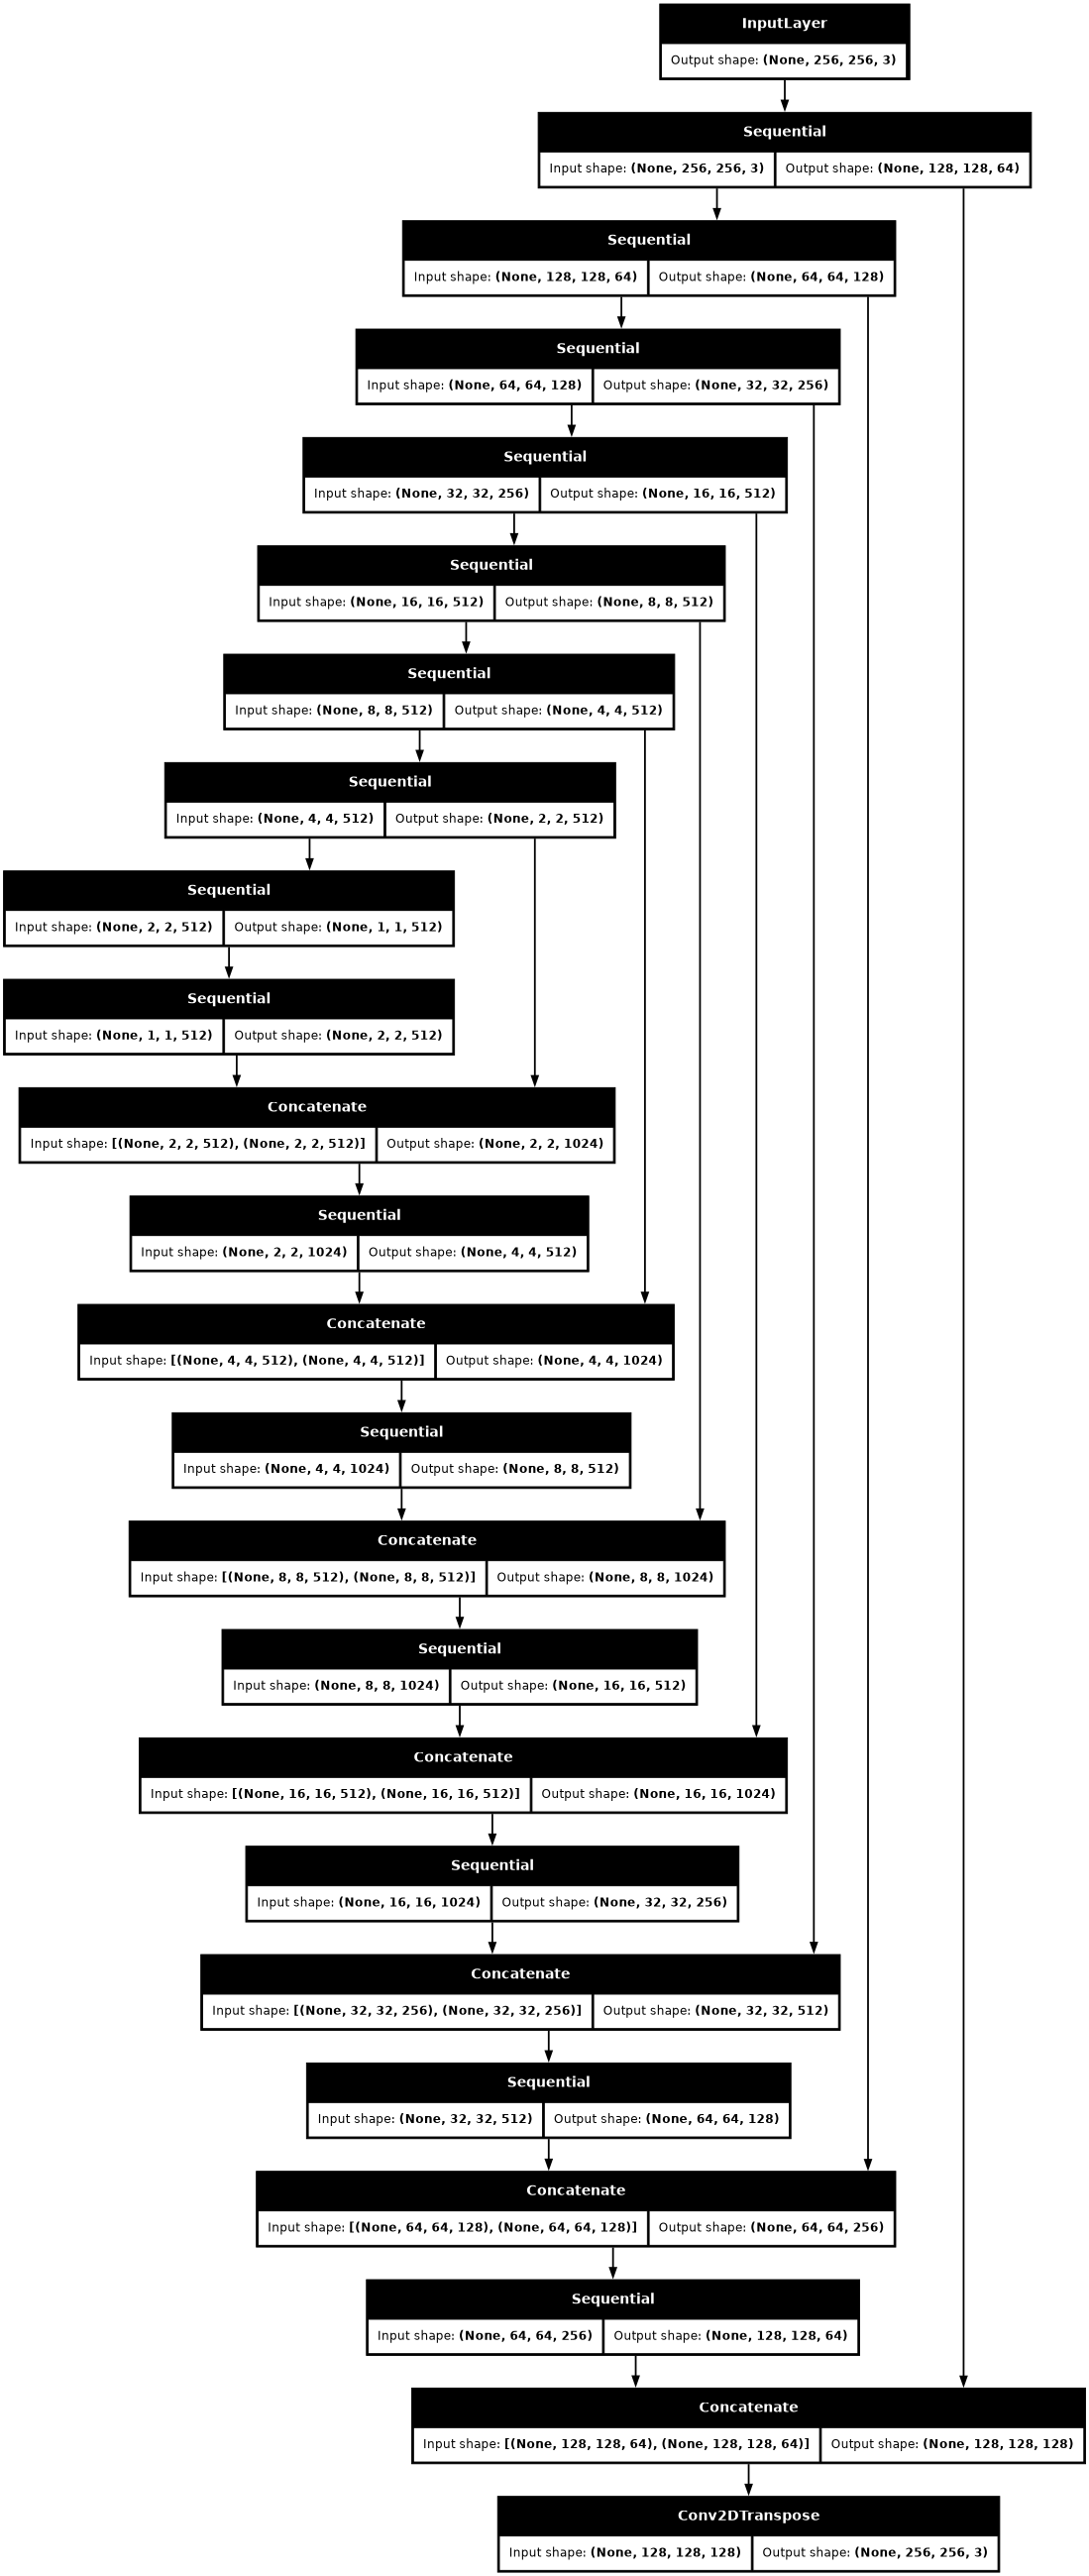

In [17]:
# Create the two generators
with strategy.scope():
    monet_generator = Generator() # Transforms photos to Monet-esque paintings
    photo_generator = Generator() # Transforms Monet paintings to be more like photos
    
# Visualize the generator architecture 
tf.keras.utils.plot_model(monet_generator, show_shapes=True, dpi=64)

### Comments on the graph

In the graph above, we can see how each layer in the encoder (downsampling stack) connects to the subsequent layer *and* to the corresponding layer in the decoder (upsampling stack).

# Discriminator

The Monet Discriminator will try to determine if an image is a real or a fake Monet (i.e. a transformed photo). The Photo Discriminator will try to decide if an image is a real or a fake photo (i.e. a transformed Monet painting).

The discriminators are built of downsampling functions and some other layers. They use a leaky ReLU activation function.

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs = inp, outputs = last)

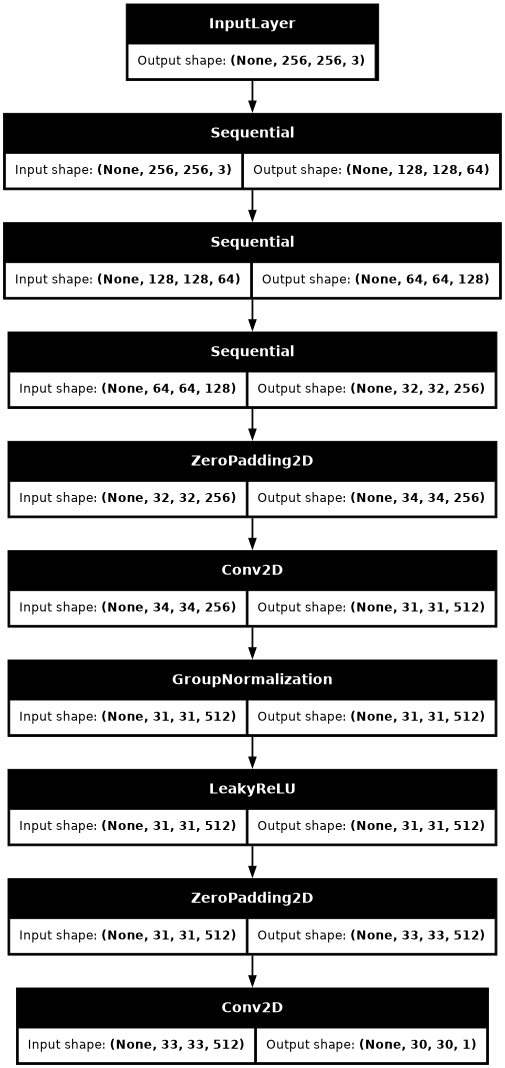

In [19]:
with strategy.scope():
    monet_discriminator = Discriminator() # Differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # Differentiates real photos and generated photos

# Visualize the discriminator architecture
tf.keras.utils.plot_model(monet_discriminator, show_shapes=True, dpi=64)

### Comments on the graph

The last layer in the Discriminators is a Convolutional 2D layer that reduces the output to a 30 x 30 grid with a single channel (30, 30, 1). This kind of output is called PatchGAN. Each element in the 30 x 30 PatchGAN grid corresponds to a patch of the image and represents the Discriminator's belief as to whether that patch is real or fake.

## CycleGAN class
We'll now put our generators and discriminators together in a class that we will use for the training.

In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Loss functions
We will define four loss functions:
* **Generator loss**: measures how well the Generators succeeded in fooling the Discriminators
* **Discriminator loss**: measures how well the Discriminators were able to tell real and fake images apart
* **Cycle consistency loss**: measures how well an image can be transformed from one domain to the other and back to the original domain, i,e. a photo transformed to a Monet and then back to a photo, how much does that look like a photo?
* **Identity loss**: Measures to what degree an image remains unaffected when it is passed through a generator that should not transform it, i.e. to what degree does a Monet painting that is passed through the *Monet* generator remain a Monet painting?

In [21]:
# Generator loss function
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [22]:
# Discriminator loss function
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [23]:
# Cycle consistency loss function
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [24]:
# Identity loss function
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Optimizers

The optimizers determine the strategy used for minimizing the loss. A crucial part of an optimizer is the learning rate, which determines how large of a step the model will take during the gradient descent. A larger learning rate will lead to faster convergence, but it may overshoot the target and end up fluctuating around the neighborhood of the smallest possible loss. A smaller learning rate means the model will take longer to converge, but that it will eventually home in on a smaller area.

In [25]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)

# **Create and train the model**

## Instantiate the model

In [26]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

## Train the model

In [27]:
%%time
# Shuffle and repeat for varied sampling each epoch
monet_ds = monet_ds.shuffle(buffer_size=300)  # Monet set is small, so we use the full buffer size
photo_ds = photo_ds.shuffle(buffer_size=1500)  # Shuffle photo set to get varied samples

# Train model with a custom steps_per_epoch if needed
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds.repeat(), photo_ds.repeat())),
    epochs=EPOCHS,
    steps_per_epoch=300  # Or more, based on experimentation
)

Epoch 1/25


2024-10-31 12:53:27.144849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/gradient_tape/functional_15_5/sequential_10_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 ━━━━━━━━━━━━━━━━━━━━ 203s 361ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 7.1789 - photo_disc_loss: 0.6056 - photo_gen_loss: 7.4094
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - monet_disc_loss: 0.5160 - monet_gen_loss: 4.8582 - photo_disc_loss: 0.5005 - photo_gen_loss: 4.9636
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - monet_disc_loss: 0.5041 - monet_gen_loss: 4.3686 - photo_disc_loss: 0.3962 - photo_gen_loss: 4.5768
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - monet_disc_loss: 0.3153 - monet_gen_loss: 4.4930 - photo_disc_loss: 0.2892 - photo_gen_loss: 4.6232
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - monet_disc_loss: 0.3927 - monet_gen_loss: 4.5529 - photo_disc_loss: 0.3295 - photo_gen_loss: 4.7523
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - monet_disc_loss: 0.4347 - monet_gen_loss: 4.4913 - photo_disc_loss: 0.3839 - photo_gen_loss: 4.5910
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 358ms/step - monet

# **Generate and show some Monet-style photos**

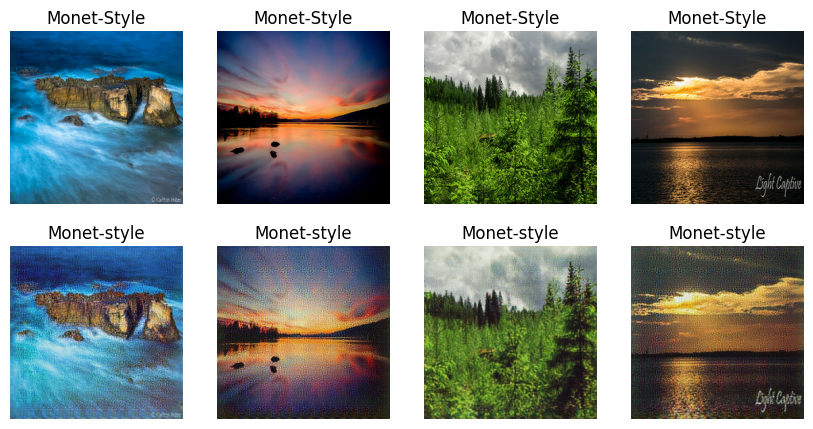

CPU times: user 5.83 s, sys: 731 ms, total: 6.57 s
Wall time: 20.1 s


In [28]:
%%time
# Calculate figsize to display images at true size
figsize = (256 * 4 / 100, 256 * 2 / 100)  # 4 columns by 2 rows, at 256x256 pixels per image

fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=100)  # Set dpi to 100 to match pixel size
for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    # Show photos
    ax[0, i].imshow(img)
    ax[0, i].set_title("Monet-Style")
    ax[0, i].axis("off")

    # Show Monet-esque version
    ax[1, i].imshow(prediction)
    ax[1, i].set_title("Monet-style")
    ax[1, i].axis("off")

plt.show()

## Comments on the images
I find the images above rather disappointing. Party this is due to their size; it's hard to say much about the style of such a small image. (I display them true to their 256 x 256 pixel size.) But to me, the purportedly Monet-style images look like slightly distorted photos overlaid with a grid of faint colored dots. If the Discriminator thinks that these images are good enough to hang on the wall and call a Monet, well, good for the Discriminator -- but as a human, I see nothing of Monet in these images. The model that generated these images placed quite high on the Kaggle leaderboard (position 16). I think Monet would have been appalled.

For comparisons, here are some images of real Monets.

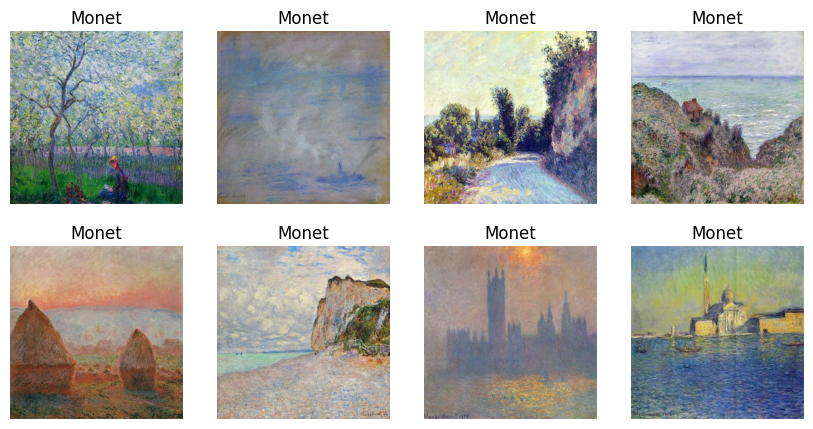

In [29]:
# Create iterables from the datasets
monet_iter = iter(monet_ds)

# Calculate figsize to display images at true size
figsize = (256 * 4 / 100, 256 * 2 / 100)  # 4 columns by 2 rows, at 256x256 pixels per image

fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=100)  # Set dpi to 100 to match pixel size

# Display 4 pairs of images
for i in range(2):
    for j in range(4):
        monet = next(monet_iter)
        ax[i, j].imshow(monet[0] * 0.5 + 0.5)
        ax[i, j].set_title("Monet")
        ax[i, j].axis('off')

plt.show()

# Create submission file

In [30]:
directory = '/kaggle/working/images'
if not os.path.exists(directory):
    os.makedirs(directory)

In [31]:
%%time
i = 1
for img in photo_ds:
    if i % 500 == 0:
        print(f"Processed {i * BATCH_SIZE} out of 7,038 images.")
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1


Processed 1000 out of 7,038 images.
Processed 2000 out of 7,038 images.
Processed 3000 out of 7,038 images.
Processed 4000 out of 7,038 images.
Processed 5000 out of 7,038 images.
Processed 6000 out of 7,038 images.
Processed 7000 out of 7,038 images.
CPU times: user 4min 9s, sys: 793 ms, total: 4min 10s
Wall time: 4min 23s


In [32]:
shutil.make_archive(base_name = "/kaggle/working/images", 
                    format = 'zip', 
                    root_dir = "/kaggle/working/images")

'/kaggle/working/images.zip'

In [33]:
# Generate a download link
filename = 'images.zip'
FileLink(rf'{filename}')

/kaggle/working/images.zip

# **Results and discussion**

Even though the fake Monets don't look anything like Monets to me, I will evaluate hyper-parameter tuning based on the MiFID scores for the Kaggle submissions.

The table below show the different combinations of hyper-parameters I tried, and the results. 
* Cells highlighted in yellow indicate that the value was changed from the immediately preceeding run.
* Cells highlighted in green are the best (i.e. lowest) score of each of the five evaluation metrics.
